In [2]:
import torch
import torch.nn as nn

In [3]:
from utils.netStructure import EncoderBlock

class BERTEncoder(nn.Module):
    """BERT encoder"""
    def __init__(self, 
                 vocab_size: int, 
                 num_hiddens: int, 
                 norm_shape: int, 
                 ffn_num_input: int, 
                 ffn_num_hiddens: int, 
                 num_heads: int, 
                 num_layers: int, 
                 dropout, 
                 max_len=1000,
                 key_size=768,
                 query_size=768,
                 value_size=768,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"block{i}", EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入矩阵
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
    
    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X   

In [4]:
vocab_size = 10000
num_hiddens = 768
ffn_num_hiddens = 1024
num_heads = 4
norm_shape = [768]
ffn_num_input = 768
num_layers = 2
dropout = 0.2
encoder = BERTEncoder(vocab_size,
                      num_hiddens,
                      norm_shape,
                      ffn_num_input,
                      ffn_num_hiddens,
                      num_heads,
                      num_layers, 
                      dropout)

In [5]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [6]:
# 掩码语言模型
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))
        
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        
        return mlm_Y_hat
    
    

In [7]:
# 下一句预测 (next sentence prediction)
class NextSentencePred(nn.Module):
    """BERT的下一句预测模块"""
    def __init__(self, num_inputs, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状是 (batch_size, 'num_hiddens')
        return self.output(X)
    
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状为(batch_size, num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat

tensor([[0.6359, 1.1323],
        [0.7565, 0.5732]], grad_fn=<AddmmBackward0>)

In [8]:
# 整合模型
from typing import Union
from torch import Tensor

class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, 
                 vocab_size: int,
                 num_hiddens: int,
                 norm_shape: Union[int, tuple],
                 ffn_num_input: int,
                 ffn_num_hiddens: int,
                 num_heads: int,
                 num_layers: int,
                 dropout: float,
                 max_len: int = 1000,
                 key_size: int = 768,
                 query_size: int = 768,
                 value_size: int = 768,
                 hid_in_features: int = 768,
                 mlm_in_features: int = 768,
                 nsp_in_features: int = 768,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = BERTEncoder(vocab_size,
                                   num_hiddens,
                                   norm_shape,
                                   ffn_num_input,
                                   ffn_num_hiddens,
                                   num_heads,
                                   num_layers,
                                   dropout,
                                   max_len=max_len,
                                   key_size=key_size,
                                   query_size=query_size,
                                   value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)
        
    def forward(self, tokens: Tensor, 
                segments: Tensor,
                valid_lens: int=None,
                pred_positions: Tensor=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [9]:
# 用于预训练BERT的数据集
import os
import random
from typing import List
import torch
from utils.dataset import DATA_HUB, Vocab, download_extract, tokenize

# 下载数据集
DATA_HUB['wikitext-2'] = (
    'https://github.com/Snail1502/dataset_d2l/blob/main/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.strip(' . ')) >= 2]
    
    return paragraphs

# 生成下一句预测任务的数据
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

# 将一个或者两个句子作为输入，然后返回BERT输入序列的标记及其相应的段索引
def get_tokens_and_segments(tokens_a: List[str], tokens_b: List[str]=None):
    """获取输入序列的词元及其索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记段A和段B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    
    return tokens, segments
    
# 下面的函数通过调用_get_next_sentence函数从输入paragraph生成用于下一句预测的训练样本。
# 这里paragraph是句子列表，其中每个句子都是词元列表。自变量max_len指定预训练期间BERT输入序列的最大长度
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph)-1):
        tokens_a, tokens_b, is_next = _get_next_sentence(paragraph[i], paragraph[i+1], paragraphs)
        # 考虑一个<cls>词元和两个<seq>词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    
    return nsp_data_from_paragraph

# 生成掩码语言模型任务的数据
def _replace_mlm_tokens(tokens: list, candidate_pred_positions: list, num_mlm_preds: int, vocab: Vocab):
    # 为掩码语言模型的输入创建新的词元副本，其中输入可能包含替换的'<mask>'词元或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后15%的随机词元用于掩码语言模型中进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%的概率替换为'<mask>'词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的概率替换为随机词元
            if random.random() < 0.1:
                masked_token = tokens[mlm_pred_position]
            # 10%的概率保持不变
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
        
    return mlm_input_tokens, pred_positions_and_labels

# 下面的函数通过调用_replace_mlm_tokens函数从输入paragraph生成用于掩码语言模型的训练样本。
def _get_mlm_data_from_tokens(tokens: list, vocab: Vocab):
    candidate_pred_postions = []
    # tokens是一个字符串列表 
    for i , token in enumerate(tokens):
        # 在掩码语言模型任务中不会使用特殊词元
        if token in ['<cls>', '<sep>']:
            continue    
        candidate_pred_postions.append(i)
    # 随机选择15%的词元进行掩码
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_postions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [x[0] for x in pred_positions_and_labels]
    mlm_pred_labels = [x[1] for x in pred_positions_and_labels]
    
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

# 将文本转化为预训练数据集，将特殊的<mask>词元附加到输入
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'词元
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 掩码语言模型的权重设置为1，非掩码语言模型的权重设置为0
        mlm_weights = [1.0] * len(token_ids) + [0.0] * (max_len - len(token_ids))
        all_mlm_weights.append(torch.tensor(mlm_weights, dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)

# Pytorch Dataloader
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs: List[List[str]], max_len: int):
        # 输入paragraophs[i]是一个代表段落的句子字符串列表
        # 输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len))
        # 获取掩码语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens, self.all_pred_positions, self.all_mlm_weights, self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)
        
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx], self.all_pred_positions[idx], self.all_mlm_weights[idx], self.all_mlm_labels[idx], self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)
    

# 通过使用_READ_WIKI函数和_WikiTextDataset类，我们定义下面的load_data_wiki来下载并生成WikiText-2数据集，以从中生成预训练样本
def load_data_wiki(batch_size: int, max_len: int):
    """加载WikiText-2数据集"""
    num_workers = 4
    # data_dir = download_extract('wikitext-2', 'wikitext-2')
    data_dir = './Database/wikitext-2/'
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
    
    return train_iter, train_set.vocab

In [10]:
data_dir = './Database/wikitext-2/'

file_name = os.path.join(data_dir, 'wiki.train.tokens')
with open(file_name, 'r') as f:
    lines = f.readlines()
# 大写字母转换为小写字母
paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.strip(' . ')) >= 2]
paragraphs

[['= valkyria chronicles iii ='],
 ['senjō no valkyria 3 : <unk> chronicles ( japanese : 戦場のヴァルキュリア3 , lit',
  'valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a tactical role @-@ playing video game developed by sega and media.vision for the playstation portable',
  'released in january 2011 in japan , it is the third game in the valkyria series',
  '<unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " nameless " , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit " <unk> raven " .'],
 ['the game began development in 2010 , carrying over a large portion of the work done on valkyria chronicles ii',
  'while it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for serie

In [11]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape, pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 64]) torch.Size([512, 10]) torch.Size([512])


In [12]:
len(vocab)
import logging.config
import logging.handlers
import json
import pathlib

def setup_logging():
    config_file = pathlib.Path('config.json')
    with open(config_file) as f_in:
        config = json.load(f_in)
    logging.config.dictConfig(config)

logger = logging.getLogger("BERT_log")
setup_logging()



MLM loss 5.197,NSP loss 0.822
4375.8 sentence pairs/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


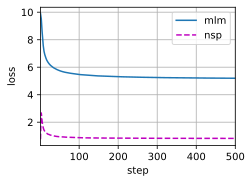

In [13]:
# 预训练BERT
from typing import Callable
import torch
from torch import nn

from utils.gpu import try_all_gpus
from utils.plot import Accumulator, Animator, Animator_vscode
from utils.timer import Timer

batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128], ffn_num_input=128, 
                ffn_num_hiddens=256, num_heads=2, num_layers=2, dropout=0.2, key_size=128,
                query_size=128, value_size=128, hid_in_features=128, mlm_in_features=128,
                nsp_in_features=128)

#！ 测试
# 初始化模型权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
net.apply(init_weights)  # 应用权重初始化

# device = 'mps'
loss = nn.CrossEntropyLoss()

# 定义辅助函数，给定训练样本，该函数计算掩码语言模型和下一句预测任务的损失。
# BERT预训练的最终损失是掩码语言模型损失和下一句预测任务损失的和
def _get_batch_loss_bert(net: BERTModel, loss: Callable, vocab_size: int, tokens_X: Tensor, 
                         segments_X: Tensor, valid_lens_x: Tensor, pred_positions_X: Tensor, 
                         mlm_weights_X: Tensor, mlm_Y: Tensor, nsp_y: Tensor):
    
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    
    # 计算掩码语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 预测下一句任务损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    
    return mlm_l, nsp_l, l


# 训练BERT模型
devices = try_all_gpus()
# devices = ['cuda:0']
num_steps = 500
vocab_size = len(vocab)


net = nn.DataParallel(net, device_ids=devices).to(devices[0])
trainer = torch.optim.Adam(net.parameters(), lr=0.01)
step, timer = 0, Timer()
animator = Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
# 掩码语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
metric = Accumulator(4)
num_steps_reached = False
while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
        tokens_X = tokens_X.to(devices[0])
        segments_X = segments_X.to(devices[0])
        valid_lens_x = valid_lens_x.to(devices[0])
        pred_positions_X = pred_positions_X.to(devices[0])
        mlm_weights_X = mlm_weights_X.to(devices[0])
        mlm_Y = mlm_Y.to(devices[0])
        nsp_y = nsp_y.to(devices[0])
        
        # 计算损失
        timer.start()
        mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, 
                                               pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
        l.backward()
        
        # 添加梯度裁剪
        #！实验一下
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            
        trainer.step()
        metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
        timer.stop()
        
        logger.info(f'MLM loss {metric[0]/metric[3]:.3f},' 
            f'NSP loss {metric[1]/metric[3]:.3f}')
        
        # 记录并打印训练进度
        animator.add(step+1, (metric[0]/metric[3], metric[1]/metric[3]))
        step += 1
        if step == num_steps:
            num_steps_reached = True
            break
        
    print(f'MLM loss {metric[0]/metric[3]:.3f},' 
          f'NSP loss {metric[1]/metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on {str(devices)}')

from matplotlib import pyplot as plt
plt.savefig(f'./figures/BERT_practice.png')

In [14]:
# 用BERT表示文本

def get_bert_encoding(net: BERTModel, tokens_a: List[str], tokens_b: List[str]=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    
    return encoded_X

考虑“a crane is flying”这句话。回想一下第14.7.4节中讨论的BERT的输入表示。

在插入特殊词元“<cls>”（用于分类）和“<sep>”（用于分离）后，BERT输入序列的长度为六。

由于零是“<cls>”to-ken的索引，encoded_text[:, 0, :]是整个输入句的BERT表示。

为了评估一词多义词元“crane”，我们还打印了令牌的BERT表示的前三个元素。

In [15]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.6022, -0.4019,  0.0366], device='cuda:0', grad_fn=<SliceBackward0>))

In [16]:
encoded_text_cls

tensor([[ 7.7571e-02, -1.4072e-03,  9.3342e-02, -7.6352e-02, -1.6429e-01,
          6.1034e-01,  1.6808e+00, -1.3614e+00, -1.5930e-01,  1.9299e-01,
          2.2977e-01, -1.2704e+00, -1.1595e+00,  8.7672e-01, -1.3678e+00,
          9.3801e-02, -1.8486e+00,  1.7387e+00,  2.6868e-03,  1.5855e+00,
          1.4288e-02, -2.7086e-02, -7.0337e-02, -3.2573e-01,  1.9689e+00,
         -3.1346e-02, -1.4230e+00,  3.4482e-01, -1.2616e+00,  2.2782e+00,
         -2.9669e-01, -4.4522e-01,  9.2680e-01, -7.5509e-02, -8.7693e-02,
          1.2436e+00, -8.4685e-02,  6.3961e-01,  3.9009e+00,  2.8163e+00,
          2.5275e-02, -4.6021e-01,  2.1983e-01, -4.0053e-01,  1.2268e-01,
          6.8398e-02, -3.7546e-01,  1.1993e+00,  8.2137e-01,  4.5327e-02,
          1.6247e+00,  8.2179e-01,  7.4283e-02, -1.1789e+00, -2.1937e-02,
          1.7257e-01, -1.0777e+00, -3.1753e+00,  1.1230e+00,  9.9348e-01,
          2.6335e-02, -5.4248e-01, -8.3043e-01,  2.0250e-01, -3.4538e-01,
          6.2021e-02,  7.5685e-01, -2.

In [19]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.7157, -0.2334,  0.1644], device='cuda:0', grad_fn=<SliceBackward0>))